**RESEARCH AND MODELLING CODES**

*Note: All codes need to be saved and run locally. The data folder needs to be put in the same path as this notebook, because the datasets will be retrieved using path names in the format `data/data_folder/dataset.csv`.*

This notebook summarises all the research and modelling processes that were performed. After scraping data using the procedures in the Data Scraping notebook, the saved datasets were imported into this notebook for further processing and modelling.

The scraping datasets in CSV format are saved to a separate `data` folder that should be put in the same path in order for this notebook to access.

# Declare all necessary libraries

In [1]:
# !pip install corextopic
# !pip install html2text

import html2text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import nltk

from nltk import word_tokenize
from nltk.corpus import words, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from string import punctuation
from collections import Counter
from corextopic import corextopic as ct

2023-05-13 10:15:28.153103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Static variables to declare

RANDOM_STATE = 1
COMPANY_NAMES = [
    'CBA',
    'BHP',
    'TLS',
    'WOW',
    'CSL'
]

DATA_SOURCES = [
    'annual report',
    'privacy policy',
    'job posts',
    'company posts'
]

In [103]:
### Import all scraped datasets
### The annual reports and privacy policies are slightly tweaked to include company names,
### and are separated for the purpose of topic modelling

datasets = [
    'data/jobs_linkedin/all_jobs_linkedin.csv',
    'data/jobs_seek/all_jobs_seek.csv',
    'data/posts_linkedin/all_posts_linkedin.csv',
    'data/annual_report/all_annual_report.csv',
    'data/privacy_policy/all_privacy_policy.csv'
]

In [4]:
def read_csv(filepath: str) -> pd.DataFrame:
    """
    Reads a filepath in CSV format and returns a Pandas DataFrame.

    ------------
    Input(s):
    filepath (str): named path of file, format is 'path/filename.csv'

    Output(s):
    pandas DataFrame representing the file.
    
    """
    return pd.read_csv(filepath)

In [104]:
datasets_dfs = list(map(read_csv, datasets))

# Data Maturity Stages: Keyword Dictionary

In [6]:
## Dictionary details
## -----------------------------------
collection = [
    'data mining',
    'mining data',
    'mine data',
    'data scraping',
    'scraping data',
    'scrape data',
    'scraping',
    'scrape',
    'data acquisition',
    'acquire data',
    'acquiring data',
    'data gathering',
    'gathering data',
    'gather data',
    'data extraction',
    'data extracting',
    'extract data',
    'extracting data',
    'data sources',
    'data retrieval',
    'data retrieving',
    'retrieving data',
    'retrieve data'
]

quality = [
    'data validation',
    'validate data',
    'validating data',
    'data validity',
    'valid data',
    'validity of data',
    'data cleaning',
    'cleaning data',
    'clean data',
    'data cleansing',
    'standardise data',
    'standardize data',
    'data standardisation',
    'data standardization',
    'pre-process data',
    'pre-process',
    'pre-processing data',
    'pre-processing',
    'data pre-processing',
    'preprocess data',
    'preprocessing data',
    'data preprocessing',
    'process data',
    'processing data',
    'data processing',
    'data accuracy',
    'accurate data',
    'data consistency',
    'consistent data',
    'consistency data',
    'relevant data',
    'data relevance',
    'data relevancy',
    'data integrity'
]

analysis = [
    'statistics',
    'statistical',
    'statistical analysis',
    'analyse data',
    'analysing data',
    'data analysis',
    'data analytics',
    'analytics',
    'machine learning',
    'artificial intelligence',
    'natural language processing',
    'deep learning',
    'ml',
    'ai',
    'nlp',
    'predictive analytics',
    'prediction',
    'predictions',
    'predicting',
    'predict',
    'predictive',
    'mathematics',
    'mathematical',
    'mathematical analysis',
    'data modelling',
    'data modeling',
    'modeling data',
    'modeling of data',
    'modelling data',
    'data model',
    'data models',
    'visualise data',
    'visualize data',
    'data visualisation',
    'data visualization',
    'visualising data',
    'visualizing data',
    'data auditing',
    'audit data',
    'auditing of data',
    'data exploration',
    'data exploring',
    'exploring data',
    'explore data',
    'dashboard',
    'dashboards'
]

culture = [
    'data driven',
    'data drive',
    'evidence',
    'evidence based',
    'analytics driven',
    'insights',
    'metrics',
    'key performance indicators',
    'kpis',
    'kpi',
    'data culture',
    'culture data'
]

governance = [
    'data privacy',
    'data usage',
    'usage data',
    'use data',
    'data security',
    'data compliance',
    'data regulations',
    'data policy',
    'data policies',
    'disseminating data',
    'dissemination of data',
    'data dissemination',
    'data disseminating'
]

monetisation = [
    'data service',
    'data services',
    'data product',
    'data products',
    'data licensing',
    'licensing data',
    'data brokerage',
    'data exchange',
    'data marketplace',
    'data as a service',
    'data-as-a-service'
]

## -----------------------------------

## Building the dictionary
data_phases = [collection, quality, analysis, culture, governance, monetisation]
DATA_DICTIONARY = {phase+1: keyword for phase, keyword in enumerate(data_phases)}

# Datasets to analyse

In [105]:
## Final datasets

jobs = pd.concat([datasets_dfs[0], datasets_dfs[1]], ignore_index=True).drop('level', axis=1)
posts = datasets_dfs[2]
annual_reports = datasets_dfs[3]
privacy_policies = datasets_dfs[4]

In [106]:
jobs.head()

,company,job_title,description
0,Woolworths Group,Data Engineering Lead,About Woolworths GroupWoolworths Group is a fo...
1,Woolworths Group,Account Executive - AGW Wholesale,About Woolworths GroupWoolworths Group is a fo...
2,Woolworths Group,HVAC & R Technician,About Woolworths GroupWoolworths Group is a fo...
3,Woolworths Group,Analytics Engineering Manager,"Lead teams in the design, development, impleme..."
4,Woolworths Group,IT Senior Business Analyst - Payments,"About UsFounded within the Woolworths group, W..."


In [107]:
jobs.shape

(1458, 3)

In [108]:
posts.head()

,company,how_long_ago,text
0,Commonwealth Bank,2d,“Eid is a time for Muslims to celebrate the en...
1,Commonwealth Bank,6d,"Leadership is about three key things: heads, h..."
2,Commonwealth Bank,1w,"“From the beginning, I felt like CommBank was ..."
3,Commonwealth Bank,1w,Lest we forget.
4,Commonwealth Bank,2w,If you're a recent graduate considering your n...


In [109]:
posts.shape

(333, 3)

In [110]:
annual_reports.head()

,company,annual_report_text
0,CBA,For the half year ended \n31 December 2022Prof...
1,CBA,2022 Annual Report\nFuture \nfor allFront cove...
2,CBA,For the half year ended 31 December 2021Profit...
3,CBA,2021 \nAnnual \nReporttoday.\nHi Sarah\nHome l...
4,CBA,For the half year ended \n31 December 2020Prof...


In [111]:
annual_reports.shape

(39, 2)

In [112]:
privacy_policies

,company,privacy_policy_text
0,CBA,"\n\n\n\n<!doctype html>\n<html lang=""en-AU"">\n..."
1,CBA,"\n\n\n\n<!doctype html>\n<html lang=""en-AU"">\n..."
2,CSL,\r\n\r\n\r\n<!DOCTYPE html>\r\n<!--[if IE 7]><...
3,CSL,\r\n\r\n\r\n<!DOCTYPE html>\r\n<!--[if IE 7]><...
4,BHP,\n1. Introduction\n\nProtecting your privacy i...
5,WOW,"\n<!DOCTYPE HTML>\n<html lang=""en"">\n <head..."
6,TLS,"\n<!DOCTYPE HTML>\n<html lang=""en"">\n\n<head>\..."


In [113]:
privacy_policies.shape

(7, 2)

# Preprocessing for text

## Text cleaning procedures

In [14]:
## Development codes for testing only
## -----------------------------------

# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# eng = set(nlp.vocab.strings)

# text = jobs['description'][1]
# text = fix_end_of_sentence(text)
# text = remove_punc(text)
# text = remove_stopwords_and_lower(text)

# attached_words = [word for word in word_tokenize(text) if lemmatize(word) not in eng]
# fixed_words = list(map(unattach, attached_words))

# word = 'fastgrowing'
# for i in range(len(word)):
#     if lemmatize(word[:i]) in eng and lemmatize(word[i:]) in eng:
#         word = f'{word[:i]} {word[i:]}'

In [15]:
## GROUP OF FUNCTIONS TO CLEAN TEXTS
## ---------------------------------

def strip_newline_char(text: str) -> str:
    """
    Cleans up newline characters in a given string of text.
    
    """
    text = text.replace('\n', ' ')
    return text


def parse_html(text: str) -> str:
    """
    Parse HTML to text for a given string of text in HTML form.
    
    """
    return html2text.html2text(text)


def fix_end_of_sentence(text: str) -> str:
    """
    Fix end of sentences, where full stops are not followed by a space.
    For example: 'driven.The' --> 'driven. The'
    
    """
    regex = re.findall('\w+\.\w+', text)
    for string in regex:
        correct_split = re.split('\.', string)
        correct_string = f'{correct_split[0]}. {correct_split[-1]}'
        text = text.replace(string, correct_string)
        
    return text


def remove_stopwords_and_lower(text: str, stop_words: list=stopwords.words('english')) -> str:
    """
    Removes stopwords from a string of text, and transforms text to lowercase.
    
    """
    text_list_lowered = text.lower().split()
    text_list_lowered = [word for word in text_list_lowered if word not in stop_words]
    return ' '.join(text_list_lowered)


def remove_punc(text: str, punc: str=punctuation) -> str:
    return ''.join([c for c in text if c not in punc])


def lemmatize(word):
    """
    Helper function to lemmatize a word.
    
    """
    lemmatizer = WordNetLemmatizer()
    return lemmatizer.lemmatize(word)


def unattach(
        word:str, 
        english_vocab: list=set(spacy.load('en_core_web_sm', disable=['parser', 'ner']).vocab.strings)
        ) -> str:
    """
    Helper function to unattach an attached word (for example: 'leadpermanent' -> 'lead permanent').
    
    A simple logic is implemented: for each split of the word, the first split that results
    in both words being in the English vocabulary are taken as solution.
    """
    for i in range(len(word)):
        if lemmatize(word[:i]) in english_vocab and lemmatize(word[i:]) in english_vocab:
            word = f'{word[:i]} {word[i:]}'
    return word


def fix_attached_words(
        text: str,
        english_vocab: list=set(spacy.load('en_core_web_sm', disable=['parser', 'ner']).vocab.strings)
        ) -> str:
    """
    Fix attached words in a string of text.
    
    """
    attached_words = [word for word in word_tokenize(text) if lemmatize(word) not in english_vocab]
    fixed_words = list(map(unattach, attached_words))
    for i in range(len(attached_words)):
        text = text.replace(attached_words[i], fixed_words[i])
    return text
    

## ---------------------------------

## WRAPPER FUNCTION TO CLEAN TEXT
def clean(text: str) -> str:
    text = parse_html(text)
    text = strip_newline_char(text)
    text = fix_end_of_sentence(text)
    text = remove_punc(text)
    text = remove_stopwords_and_lower(text)
    text = fix_attached_words(text)
    
    return text

# Topic modelling

These commented blocks of code represent development codes only, in order to build functions later on. To see the complete NLP pipeline, please scroll down towards **NLP Pipeline: Building a data maturity scoring system**.

## Semi-supervised topic modelling for jobs

In [16]:
### DEVELOPMENT CODE FOR LOGIC TESTING ONLY

# ## WRAPPER FUNCTION TO CLEAN TEXT FOR TOPIC MODELLING

# def clean_for_topic_modelling(text: str) -> str:
#     text = parse_html(text)
#     text = strip_newline_char(text)
#     text = fix_end_of_sentence(text)
#     text = remove_punc(text)
#     text = remove_stopwords_and_lower(text)
#     text = fix_attached_words(text)
#     text_lemmatized = ' '.join(list(map(lemmatize, text.split())))
    
#     return text_lemmatized

In [17]:
# jobs_tm = jobs.copy()
# jobs_tm['description_cleaned'] = jobs_tm['description'].apply(clean)

In [18]:
# jobs_tm.head()

In [19]:
# jobs_tm['company'].unique()

In [20]:
# jobs_tm['company'] = jobs_tm['company'].map(
#     {
#         'Woolworths Group': 'WOW',
#         'Telstra Health': 'TLS',
#         'Telstra': 'TLS',
#         'Telstra Purple': 'TLS',
#         'Commonwealth Bank': 'CBA',
#         'BHP': 'BHP',
#         'CSL Seqirus': 'CSL',
#         'PharmiWeb.Jobs: Global Life Science Jobs': 'CSL',
#         'CSL Behring': 'CSL',
#         'Randstad Australia': 'CSL',
#         'Commonwealth Bank of Australia': 'CBA',
#         'CSL Limited': 'CSL'
#     }
# )

In [21]:
# jobs_tm

In [22]:
# # Join all words to create a single corpus
# all_words = ', '.join(list(jobs_tm['description_cleaned'].values)).split()

# # Count and find the most frequent terms
# counter = Counter(all_words)
# most_frequent = counter.most_common(50)

# # Plotting frequent words
# fig = plt.figure(1, figsize = (20,10))

# _ = pd.DataFrame(
#     most_frequent,
#     columns=('Words', 'Count of words'))

# sns.barplot(x = 'Words', y = 'Count of words', data = _, palette = 'winter')
# plt.xticks(rotation=45)

In [23]:
# vectorizer = TfidfVectorizer(
#     max_features=None,
#     ngram_range=(1, 2),
#     norm=None,
#     binary=True,
#     use_idf=False,
#     sublinear_tf=False
# )

# vectorizer = vectorizer.fit(jobs_tm['description_cleaned'])
# tfidf = vectorizer.transform(jobs_tm['description_cleaned'])
# vocab = vectorizer.get_feature_names_out()

In [24]:
# anchors = [
#     ['data'],
#     ['analytics'],
#     []
# ]

# anchors = [[a for a in topic if a in vocab] for topic in anchors]

# corex_with_anchors = ct.Corex(n_hidden=3, seed=RANDOM_STATE).fit(tfidf, words=vocab, anchors=anchors, anchor_strength=5)

In [25]:
# for i, topic_ngrams in enumerate(corex_with_anchors.get_topics(n_words=10)):
#     topic_ngrams = [ngram[0] for ngram in topic_ngrams if ngram[1] > 0]
#     print(f'Topic {i}: {", ".join(topic_ngrams)}')

In [26]:
# np.set_printoptions(suppress=True)
# topic_likelihood = np.round(corex_with_anchors.p_y_given_x, 0).astype(np.int8)
# topic_likelihood

In [27]:
# data_text_indices = [i for i, sample in enumerate(topic_likelihood) if sample[0] == 1 or sample[1] == 1]
# nondata_text_indices = [i for i, sample in enumerate(topic_likelihood) if sample[2] == 1]

In [28]:
# data_jobs_tm = jobs_tm.loc[data_text_indices]

In [29]:
# data_jobs_tm.reset_index(drop=True, inplace=True)

In [30]:
# idf_vectorizer = TfidfVectorizer(
#     max_features=None,
#     ngram_range=(1, 2),
#     norm='l2'
# )

# tf_idf = idf_vectorizer.fit_transform(data_jobs_tm['description_cleaned'])

In [31]:
# for term in idf_vectorizer.get_feature_names_out():
#     if 'data' in term or 'analytics' in term:
#         print(term)

## Topic modelling for data maturity stages

In [32]:
### DEVELOPMENT CODE FOR LOGIC TESTING ONLY

# data_vectorizer = TfidfVectorizer(
#     max_features=None,
#     ngram_range=(1, 2),
#     norm=None,
#     binary=True,
#     use_idf=False,
#     sublinear_tf=False
# )

# data_vectorizer = data_vectorizer.fit(data_jobs_tm['description_cleaned'])
# data_tfidf = data_vectorizer.transform(data_jobs_tm['description_cleaned'])
# data_vocab = data_vectorizer.get_feature_names_out()

# data_anchors = data_phases

# data_anchors = [[a for a in topic if a in data_vocab] for topic in data_anchors]

# data_corex = ct.Corex(
#     n_hidden=len(data_phases), 
#     seed=RANDOM_STATE
# ).fit(data_tfidf, words=data_vocab, anchors=data_anchors, anchor_strength=5)

In [33]:
# topics = data_corex.get_topics()
# for topic_n, topic in enumerate(topics):
#     # w: word, mi: mutual information, s: sign
#     topic = [(w, mi, s) if s > 0 else ('~'+w, mi, s) for w, mi, s in topic]
#     # Unpack the info about the topic
#     words, mis, signs = zip(*topic)    
#     # Print topic
#     topic_str = f"Topic {topic_n+1}: {', '.join(words)}"
#     print(topic_str)

## Scoring for each company for the Jobs dataset

In [34]:
### DEVELOPMENT CODE FOR LOGIC TESTING ONLY

# # data_phases = [collection, quality, analysis, culture, governance, monetisation]

# idx_collection = np.argwhere(data_topic_likelihood[:, 0] == 1).reshape(-1, )
# idx_quality = np.argwhere(data_topic_likelihood[:, 1] == 1).reshape(-1, )
# idx_analysis = np.argwhere(data_topic_likelihood[:, 2] == 1).reshape(-1, )
# idx_culture = np.argwhere(data_topic_likelihood[:, 3] == 1).reshape(-1, )
# idx_governance = np.argwhere(data_topic_likelihood[:, 4] == 1).reshape(-1, )
# idx_monetisation = np.argwhere(data_topic_likelihood[:, 5] == 1).reshape(-1, )

# collection_df = data_jobs_tm.loc[idx_collection].reset_index(drop=True)
# quality_df = data_jobs_tm.loc[idx_quality].reset_index(drop=True)
# analysis_df = data_jobs_tm.loc[idx_analysis].reset_index(drop=True)
# culture_df = data_jobs_tm.loc[idx_culture].reset_index(drop=True)
# governance_df = data_jobs_tm.loc[idx_governance].reset_index(drop=True)
# monetisation_df = data_jobs_tm.loc[idx_monetisation].reset_index(drop=True)

In [35]:
# ## INSPECTING THE SHAPE OF EACH DATASET

# dfs = [
#     collection_df,
#     quality_df,
#     analysis_df,
#     culture_df,
#     governance_df,
#     monetisation_df
# ]
# for df in dfs:
#     print(df.shape)

In [36]:
# ## SCORING

# dtm_vocab = {i+1: get_norm_tfidf(df['description_cleaned']) for i, df in enumerate(dfs)}

In [37]:
# dtm_vocab

In [38]:
# plt.hist(dtm_vocab[1][0].data)

In [39]:
# ## DATA COLLECTION DF

# # collection_cba_indices = collection_df.loc[collection_df['company'] == 'CBA'].index
# quality_cba_indices = quality_df.loc[collection_df['company'] == 'CBA'].index

In [40]:
# dtm_cba = dtm_vocab[2][0][quality_cba_indices, :]
# dtm_cba

In [41]:
# for i in quality:
#     if i in dtm_vocab[2][1]:
#         print(i)

In [42]:
# idx = int(np.where(dtm_vocab[2][1] == 'data processing')[0])  ## Need to fix indexing [?][1]
# idx 

In [43]:
# dtm_cba[:, idx].data

# NLP Pipeline: Building a data maturity scoring system

The system used to score the company is based on data maturity ranking:

- 1: Data collection
- 2: Data quality
- 3: Data analysis
- 4: Data culture
- 5: Data governance
- 6: Data monetisation

The score will be offset according to TF-IDF scores for each term found in a category. After retrieving all TF-IDF scores, a weighted average will be calculated for a single company. For example let's take company WOW for the jobs dataset:

- 5 terms found for data collection: $t_1^{dc},...,t_5^{dc}$
- 5 terms found for data quality: $t_1^{dq},...,t_5^{dq}$
- 5 terms found for data analysis: $t_1^{da},...,t_5^{da}$
- 3 terms found for data culture: $t_1^{dcu},...,t_3^{dcu}$
- 2 terms found for data governance: $t_1^{dg},t_2^{dg}$
- 1 term found for data monetisation: $t_1^{dm}$

Each of the terms above has its own TF-IDF score, and each term is also weighted by its category (e.g. data quality has weight 2). Therefore the score for WOW for the jobs dataset is the weighted average of its TF-IDFs:

$$\text{Score}_{\text{wow}} = \frac{1 \times \big(\text{tf_idf}_1^{dc} + ... + \text{tf_idf}_5^{dc}\big) + 2 \times \big(\text{tf_idf}_1^{dq} + ... +\text{tf_idf}_5^{dq}\big) + ... + 6 \times \big(\text{tf_idf}_1^{dm}\big)}{1+2+...+6}$$

*(The weighted sum/average will not be explicitly calculated within the pipeline. Scores will be weighted separately when the final summary dataset is compiled. This is for interpretation purposes.)*

This scoring system takes into account the number of terms seen in a category, but offset by its observed importance within that collection of documents. This makes sure that a company with more rows in the dataset does not necessarily take a higher score simply because there's a higher chance of it having more terms.

The modelling will be performed via the following NLP pipeline:

- `run_initial_corex_topic_model()`: to filter the original dataset into data-related and non-data-related texts. This only applies to a certain data category, such as job postings and company updates, since not all samples are of data-related interest. It returns a filtered dataset, representing texts that are likely to be data-related.

- `get_norm_tfidf()`: to get the normalised tf-idf scores for scoring companies. This function will be applied to data-related texts, and returns a document-term matrix (DTM) and a vocabulary, representing the tf-idf scores for all terms in the data-related texts. The scoring function later down the pipeline will retrieve a portion of this DTM to calculate the score for a single company, for a single data maturity stage.

- `get_vocabulary()`: to retrieve the vocabulary for a single company, for a single data maturity stage.

- `run_corex_topic_model()`: this is the main CorEx topic model to run, where the data-related texts will be sub-divided into six overlapping "clusters", where each cluster represents the collection of documents that are likely from one of the six maturity stages. The clusters overlap because there can be more than one data maturity stage present in a single document. This function returns a binary topic likelihood matrix, where each row encodes information about whether this sample is likely to belong to a particular cluster. Each sample may belong to multiple clusters, so a single row of this matrix can be, for instance, `[0, 1, 0, 0, 1, 0]`, denoting that this sample likely belongs to stages two and five of the data maturity model.

- `company_score_by_maturity_stage()`: this is the main scoring function, where the score is calculated for a single company in a single data maturity stage. This is later wrapped by another function to calculate the score for a single company for all data maturity stages.

- `company_score_all_stages()`: wrapper function for `company_score_by_maturity_stage()`, to calculate the score for a single company for all stages. This function returns a list of six elements, and will be run for all companies to gather data for a summary table.

- `create_category_df()`: after scores are calculated for all companies and all stages, this function wraps the information into a Pandas DataFrame for analysis and interpretation.

The following cells define the above functions for the pipeline.

---

In [44]:
### USE THIS FUNCTION TO GET DATA-RELATED TEXTS FOR THE ORIGINAL DATASET

def run_initial_corex_topic_model(
    df: pd.DataFrame, 
    text_column: str,
    data_dict: dict=DATA_DICTIONARY,
    seed: int=1) -> pd.DataFrame:
    """
    Runs the first CorEx topic model on the data, to identify potential data-related texts.
    
    ------------
    Input(s):
    df (pd.DataFrame): The cleaned dataset
    text_column (str): The name of the column in df that contains the text data to mine
    anchors (list): List of lists, with each sub-list representing the anchored words of that topic
    seed (int, default=1): the random seed of the CorEx algorithm.
    
    ----------
    Output(s):
    data_df (pd.DataFrame): The data-related DataFrame, as learned by the CorEx topic model.
    
    """
    # Initialise the tfidf vectorizer specific to the CorEx topic model, as advised by model 
    # authors. This is because the CorEx model is optimised to run on binary vectorizers.
    vectorizer = TfidfVectorizer(
        max_features=None,
        ngram_range=(1, 2),
        norm=None,
        binary=True,
        use_idf=False,
        sublinear_tf=False
    )
    
    # Fit the dataset, then transform to get the document-term matrix and the vocabulary
    vectorizer = vectorizer.fit(df[text_column])
    tfidf = vectorizer.transform(df[text_column])
    vocab = vectorizer.get_feature_names_out()
    
    # Define the initial anchored topics: the data dictionary is a reliable starting point. Also, 
    # two generic topics, 'data' and 'analytics' are also included for catching texts with
    # single words that don't fit into any of the stages.
    
    data_topic = []
    for i in data_dict.values():
        data_topic += i
    
    anchors = [
        ['data'],  # generic topic
        ['analytics'],  # generic topic
        data_topic,  # all data-related topics derived from data dictionary
        []
    ]
     
    # Filter the anchors to include all vocab terms that contain anchored terms. This is a cleaning
    # step for the topic model, and is recommended by the model authors. See example of CorEx:
    # https://gist.github.com/patrickvankessel/0d5bd690910edece831dbdf32fb2fb2d
    
    anchors_filtered = [[a for a in topic if a in vocab] for topic in anchors]

    # Initialise and fit the CorEx model, using the inputs created above. After experimenting with
    # anchor strengths from 1 to 5, 5 seems to produce the most related results.
    anchored_corex = ct.Corex(
        n_hidden=len(anchors), 
        seed=seed
    ).fit(tfidf, words=vocab, anchors=anchors_filtered, anchor_strength=5)
    
    # Retrieve the binary topic likelihood matrix of shape (n_samples, n_topics), which shows
    # which topic(s) the samples are likely to fall into. One sample may fall into more than
    # one topic.
    topic_likelihood = anchored_corex.transform(tfidf).astype(np.int8)
    
    # Filter row indices where the data topics are identified
    data_indices = [i for i, sample in enumerate(topic_likelihood) if sample[0] == True or sample[1] == True or sample[2] == True]
    data_df = df.loc[data_indices].reset_index(drop=True)
    
    # Return the filtered dataset, which represent the data-related texts
    return data_df

In [45]:
def get_norm_tfidf(data: pd.Series) -> (np.ndarray, np.ndarray):
    """
    Get the normalised document-term matrix (TF-IDF), and the vocabulary array.
    
    """
    
    tfidf_vec = TfidfVectorizer(
        max_features=None,
        ngram_range=(1, 2),
        norm='l2'
    )
    
    doc_term_matrix = tfidf_vec.fit_transform(data)
    vocabulary = tfidf_vec.get_feature_names_out()
    
    return doc_term_matrix, vocabulary

In [82]:
def get_vocabulary(data: pd.Series) -> np.ndarray:
    """
    Fit a normalised TF-IDF vectorizer, but does not transform. Returns learned vocabulary only.
    This function is only useful for retrieving the portion of vocabulary for a single company 
    and a single data stage, which is utilised in the scoring function.
    
    """
    tfidf_vec = TfidfVectorizer(
        max_features=None,
        ngram_range=(1, 2),
        norm='l2'
    ).fit(data)
    
    vocabulary = tfidf_vec.get_feature_names_out()
    
    return vocabulary

In [46]:
def run_corex_topic_model(
    data_df: pd.Series, 
    data_maturity_dict: dict=DATA_DICTIONARY, 
    seed: int=1) -> np.ndarray:
    """
    Runs a semi-supervised CorEx topic model, using anchored words from the data maturity
    dictionary. This function should use data-related texts only, rather than the original 
    unfiltered dataset.
    
    ------------
    Input(s):
    data_df (pd.DataFrame): The data-related texts only
    data_maturity_dict (dict): The data maturity dictionary, as defined at the beginning
    seed (int, default=1): the random seed of the CorEx algorithm.
    
    ----------
    Output(s):
    data_topic_likelihood (np.ndarray): The binary topic likelihood matrix
    
    """
    # Initialise the tfidf vectorizer specific to the CorEx topic model, as advised by model 
    # authors. This is because the CorEx model is optimised to run on binary vectorizers.
    data_vectorizer = TfidfVectorizer(
        max_features=None,
        ngram_range=(1, 2),
        norm=None,
        binary=True,
        use_idf=False,
        sublinear_tf=False
    )

    # Fit the dataset, then transform to get the document-term matrix and the vocabulary
    data_vectorizer = data_vectorizer.fit(data_df)
    data_tfidf = data_vectorizer.transform(data_df)
    data_vocab = data_vectorizer.get_feature_names_out()

    # Design the anchored topics list, which consist of 6 sub-lists representing data maturity stages
    data_anchors = list(data_maturity_dict.values())
    data_anchors = [[a for a in topic if a in data_vocab] for topic in data_anchors]

    # Runs the CorEx model on the data
    data_corex = ct.Corex(
        n_hidden=len(data_anchors), 
        seed=seed
    ).fit(data_tfidf, words=data_vocab, anchors=data_anchors, anchor_strength=5)
    
    # Retrieve the data topic likelihood by getting CorEx to transform the learned document-term matrix
    data_topic_likelihood = data_corex.transform(data_tfidf).astype(np.int8)
    
    return data_topic_likelihood

In [118]:
def company_score_by_maturity_stage(
    company: str, 
    topic_likelihood: np.ndarray,
    data_df: pd.DataFrame,
    text_col: str,
    stage: int,
    data_maturity_dict: dict=DATA_DICTIONARY,
    verbose: bool=True) -> float:
    """
    Score for an individual company by a specific data maturity stage.
    
    ------------
    Input(s):
    company (str): The short name for the company, e.g. 'WOW'
    topic_likelihood (np.ndarray): The binary topic likelihood array of shape (n_samples, n_topics),
        as learned by CorEx.
    data_df (pd.DataFrame): the data-related dataset after being run through initial topic modelling
    text_col (str): the column containing the texts in the data df, for pipeline use only
    stage (int): the numerically-encoded stage of the data maturity model
    data_maturity_dict (dict): the defined data maturity dictionary. Defaults to the initially
        defined data dictionary
    verbose (bool): whether to print terms and their TF-IDF scores. Defaults to True
    
    ----------
    Output(s):
    sum_score_company (float): the sum of the TF-IDF scores for the company, for the specified
        maturity stage.
    
    """
    range_stages = range(1, len(data_maturity_dict)+1)
    assert stage in range_stages, f'The stage number needs to be from {min(range_stages)} to {max(range_stages)}.'
    
    # Get the normalised TF-IDF matrix for the data-related texts
    data_dtm, data_vocabulary = get_norm_tfidf(data_df[text_col])
    
    # Get the indices of the rows in the dataset where texts implying the current data maturity
    # stage are deemed present
    idx_stage = np.argwhere(topic_likelihood[:, stage-1] == True).reshape(-1, )
    
    # Then retrieve the dataset containing this particular stage
    stage_df = data_df.loc[idx_stage]
    
    # Get the indices in the stage-specific data that is from the company of interest
    idx_company = stage_df.loc[stage_df['company'] == company].index
    
    # Get the stage-specific data for the company of interest
    stage_company_df = stage_df.loc[idx_company]
    
    # Get the column that has the actual text data from the stage-specific company dataset
    stage_company_textual_data = stage_company_df[text_col]
    
    # Learn the vocabulary specific to this company and this stage, in order to compare tf-idf
    # with the larger corpus
    try:
        stage_company_vocabulary = get_vocabulary(stage_company_textual_data)
    except ValueError as no_vocab_found:
        if verbose:
            print(f'No vocabulary found for {company} in stage {stage}, or vocabulary only contains stopwords.')
        return 0
    
    # Filter the appearing data-related terms for this company and this stage
    appearing_terms = [term for term in data_maturity_dict[stage] if term in stage_company_vocabulary]
    
    # Look for the indices of these terms in the larger vocabulary, which is a superset of
    # the stage-company-specific vocabulary
    term_idx = [int(np.where(data_vocabulary == term)[0]) for term in appearing_terms]
    
    # Compute each term's TF-IDF score. Each score is a np.sum because it may appear in several
    # documents, each one having a different score because of a different TF.
    term_tfidf = [np.sum(data_dtm[:, idx].data) for idx in term_idx]
    
    # Take a sum across the tf-idf scores for all terms, to represent the final score for this
    # company at this stage
    sum_score_company = sum(term_tfidf)
    
    if verbose:
        print(f'Appearing terms in stage {stage}: {appearing_terms}')
        print(f'Term TF-IDF: {term_tfidf}')
        print(f'Sum of scores for stage {stage}: {sum_score_company}')
        print()
    
    return sum_score_company

In [48]:
def company_score_all_stages(
    company: str, 
    topic_likelihood: np.ndarray,
    data_df: pd.DataFrame,
    text_col: str,
    verbose: bool=True) -> float:
    """
    Wrapper function to compute company scores for all stages of the maturity model.
    
    """
    stages = range(1, 7)
    
    stage_scores = [
        company_score_by_maturity_stage(
            company=company,
            topic_likelihood=topic_likelihood,
            data_df=data_df,
            text_col=text_col,
            stage=stage,
            verbose=verbose
        )
        for stage in stages
    ]
    
    return stage_scores

In [73]:
def create_category_df(scores: dict, data_category: str) -> pd.DataFrame:
    """
    Puts all scores data into a pandas DataFrame.
    
    """
    summary_column_names = [f'maturity_stage_{i}' for i in range(1, 7)]
    
    category_df = pd.DataFrame(
        scores
    ).transpose().rename(
        {k: name for k, name in enumerate(summary_column_names)},
        axis='columns'
    )
    
    category_df.reset_index(inplace=True)
    
    category_df.insert(1, 'data_source', data_category)
    
    category_df.rename(
        columns={"index": 'company'},
        inplace=True
    )
    
    return category_df 

# Run pipeline: Job postings

In [49]:
jobs_work = jobs.copy()
jobs_work['description'] = jobs_work['description'].apply(clean)
jobs_work

,company,job_title,description
0,Woolworths Group,Data Engineering Lead,woolworths group woolworths group food everyda...
1,Woolworths Group,Account Executive - AGW Wholesale,woolworths group woolworths group food everyda...
2,Woolworths Group,HVAC & R Technician,woolworths group woolworths group food everyda...
3,Woolworths Group,Analytics Engineering Manager,lead teams design development implementation s...
4,Woolworths Group,IT Senior Business Analyst - Payments,us founded within woolworths group w pay unpar...
...,...,...,...
1453,Telstra,Part-time Customer Service & Sales Consultant ...,employment type permanent closing date 24 may ...
1454,Telstra,Security Architecture - Senior Architect,employment type permanent closing date 15 may ...
1455,Telstra,Part-time Customer Service & Sales Consultant ...,employment type permanent closing date 23 may ...
1456,Telstra,Senior Cyber Security Risk and Assurance Lead,employment type permanent closing date 16 may ...


In [50]:
jobs_work['company'].unique()

array(['Woolworths Group', 'Telstra Health', 'Telstra', 'Telstra Purple',
       'Commonwealth Bank', 'BHP', 'CSL Seqirus',
       'PharmiWeb.Jobs: Global Life Science Jobs', 'CSL Behring',
       'Randstad Australia', 'Commonwealth Bank of Australia',
       'CSL Limited'], dtype=object)

In [51]:
jobs_work['company'] = jobs_work['company'].map(
    {
        'Woolworths Group': 'WOW',
        'Telstra Health': 'TLS',
        'Telstra': 'TLS',
        'Telstra Purple': 'TLS',
        'Commonwealth Bank': 'CBA',
        'BHP': 'BHP',
        'CSL Seqirus': 'CSL',
        'PharmiWeb.Jobs: Global Life Science Jobs': 'CSL',
        'CSL Behring': 'CSL',
        'Randstad Australia': 'CSL',
        'Commonwealth Bank of Australia': 'CBA',
        'CSL Limited': 'CSL'
    }
)

In [52]:
data_jobs_df = run_initial_corex_topic_model(
    df=jobs_work, 
    text_column='description')

In [53]:
data_jobs_df

,company,job_title,description
0,WOW,Data Engineering Lead,woolworths group woolworths group food everyda...
1,WOW,Account Executive - AGW Wholesale,woolworths group woolworths group food everyda...
2,WOW,HVAC & R Technician,woolworths group woolworths group food everyda...
3,WOW,Analytics Engineering Manager,lead teams design development implementation s...
4,WOW,IT Senior Business Analyst - Payments,us founded within woolworths group w pay unpar...
...,...,...,...
1244,TLS,Full Time Customer Service & Sales Consultant ...,specifics telstra store don caster shop g05961...
1245,TLS,Part-time Customer Service & Sales Consultant ...,employment type permanent closing date 24 may ...
1246,TLS,Part-time Customer Service & Sales Consultant ...,employment type permanent closing date 23 may ...
1247,TLS,Senior Cyber Security Risk and Assurance Lead,employment type permanent closing date 16 may ...


In [80]:
jobs_topic_likelihood = run_corex_topic_model(
    data_jobs_df['description']
)

In [90]:
job_scores = {}

for company in COMPANY_NAMES:
    print(f'Showing results for {company}:')
    job_scores[company] = company_score_all_stages(
        company=company,
        topic_likelihood=jobs_topic_likelihood,
        data_df=data_jobs_df,
        text_col='description'
    )
    print('----------------------')

Showing results for CBA:
Appearing terms in stage 1: []
Term TF-IDF: []
Sum of scores for stage 1: 0

Appearing terms in stage 2: ['process data', 'data processing', 'data integrity']
Term TF-IDF: [0.32367905504417815, 0.18487942620064218, 0.6363917134580104]
Sum of scores for stage 2: 1.1449501947028307

Appearing terms in stage 3: ['statistics', 'statistical', 'statistical analysis', 'analyse data', 'data analysis', 'data analytics', 'analytics', 'machine learning', 'artificial intelligence', 'ml', 'ai', 'predicting', 'mathematics', 'mathematical', 'dashboard', 'dashboards']
Term TF-IDF: [0.5870935624355789, 0.863072338386937, 0.18112439989142887, 0.038839252174225805, 0.6342866138590773, 1.5675442449700663, 3.8187359979875426, 0.41410180239400385, 0.22702973975877255, 0.7933414330204865, 0.3201360717053666, 0.04322071537773095, 0.27264677331165327, 0.21038920381719986, 0.09680697685845246, 0.5483005172763243]
Sum of scores for stage 3: 10.616669643224848

Appearing terms in stage 4:

# Run pipeline: Privacy Policies

In [56]:
pp_work = privacy_policies.copy()
pp_work['privacy_policy_text'] = pp_work['privacy_policy_text'].apply(clean)
pp_work

,company,privacy_policy_text
0,CBA,skip main content skip log skip search accessi...
1,CBA,skip main content skip log skip search accessi...
2,CSL,skip main content appcommonimages2 3logowedge ...
3,CSL,skip main content appcommonimages2 3logowedge ...
4,BHP,1 introduction protecting privacy important us...
5,WOW,woolworths groupcontentdamwwgsiteresourcesauth...
6,TLS,publisher telstra name telstra privacy telstra...


In [57]:
pp_topic_likelihood = run_corex_topic_model(pp_work['privacy_policy_text'])

In [91]:
pp_scores = {}

for company in COMPANY_NAMES:
    print(f'Showing results for {company}:')
    pp_scores[company] = company_score_all_stages(
        company=company,
        topic_likelihood=pp_topic_likelihood,
        data_df=pp_work,
        text_col='privacy_policy_text'
    )
    print('----------------------')

Showing results for CBA:
Appearing terms in stage 1: ['data sources']
Term TF-IDF: [0.004790714492193475]
Sum of scores for stage 1: 0.004790714492193475

Appearing terms in stage 2: ['relevant data']
Term TF-IDF: [0.012299849525071124]
Sum of scores for stage 2: 0.012299849525071124

Appearing terms in stage 3: ['statistics', 'analytics', 'predict']
Term TF-IDF: [0.004790714492193475, 0.02820666733192472, 0.004790714492193475]
Sum of scores for stage 3: 0.03778809631631167

Appearing terms in stage 4: ['insights']
Term TF-IDF: [0.05244497865395915]
Sum of scores for stage 4: 0.05244497865395915

Appearing terms in stage 5: ['data privacy', 'use data']
Term TF-IDF: [0.04840880570095354, 0.004790714492193475]
Sum of scores for stage 5: 0.05319952019314701

Appearing terms in stage 6: []
Term TF-IDF: []
Sum of scores for stage 6: 0

----------------------
Showing results for BHP:
No vocabulary found for BHP in stage 1, or vocabulary only contains stopwords.
No vocabulary found for BHP in

# Run pipeline: Annual reports

In [59]:
### CLEAN ANNUAL REPORTS DATA

ar_work = annual_reports.copy()
ar_work['annual_report_text'] = ar_work['annual_report_text'].apply(clean)
ar_work

,company,annual_report_text
0,CBA,hal f year en ded 31 dec em ber 20 22profit a ...
1,CBA,20 22 annual r eport fu t ure all f ront co ve...
2,CBA,half year en ded 31 dec em ber 2 021prof it an...
3,CBA,2 021 annual r eport today hi sarah home loan ...
4,CBA,hal f ye ar en ded 31 dec em ber 2020 pr ofit ...
5,CBA,2020 annual re port we toget her cre ate va lu...
6,CBA,hal f ye ar en ded 31 dec em ber 2019 prof it ...
7,CSL,immediate release 14 february 2023 results ann...
8,CSL,immediate release 17 august 20 22 re sults ann...
9,CSL,immediate release 16 february 20 22 results an...


In [60]:
ar_topic_likelihood = run_corex_topic_model(ar_work['annual_report_text'])

In [92]:
ar_scores = {}

for company in COMPANY_NAMES:
    print(f'Showing results for {company}:')
    ar_scores[company] = company_score_all_stages(
        company=company,
        topic_likelihood=ar_topic_likelihood,
        data_df=ar_work,
        text_col='annual_report_text'
    )
    print('----------------------')

Showing results for CBA:
Appearing terms in stage 1: []
Term TF-IDF: []
Sum of scores for stage 1: 0

Appearing terms in stage 2: []
Term TF-IDF: []
Sum of scores for stage 2: 0

Appearing terms in stage 3: ['ml', 'ai']
Term TF-IDF: [0.01973258571764895, 0.04251298609251927]
Sum of scores for stage 3: 0.062245571810168224

Appearing terms in stage 4: ['data driven', 'insights', 'metrics']
Term TF-IDF: [0.0030240248973772105, 0.01649597832687191, 0.07313141460844307]
Sum of scores for stage 4: 0.09265141783269218

Appearing terms in stage 5: ['use data']
Term TF-IDF: [0.005794281930618782]
Sum of scores for stage 5: 0.005794281930618782

Appearing terms in stage 6: []
Term TF-IDF: []
Sum of scores for stage 6: 0

----------------------
Showing results for BHP:
Appearing terms in stage 1: ['data sources']
Term TF-IDF: [0.001354118698304102]
Sum of scores for stage 1: 0.001354118698304102

Appearing terms in stage 2: []
Term TF-IDF: []
Sum of scores for stage 2: 0

Appearing terms in stag

# Run pipeline: LinkedIn Company updates

In [62]:
posts_work = posts.copy()
posts_work['company'].unique()

array(['Commonwealth Bank', 'Woolworths Group', 'Telstra', 'BHP', 'CSL'],
      dtype=object)

In [63]:
posts_work['company'] = posts_work['company'].map(
    {
        'Woolworths Group': 'WOW',
        'Telstra': 'TLS',
        'Commonwealth Bank': 'CBA',
        'BHP': 'BHP',
        'CSL': 'CSL'
    }
)

In [64]:
posts_work.head()

,company,how_long_ago,text
0,CBA,2d,“Eid is a time for Muslims to celebrate the en...
1,CBA,6d,"Leadership is about three key things: heads, h..."
2,CBA,1w,"“From the beginning, I felt like CommBank was ..."
3,CBA,1w,Lest we forget.
4,CBA,2w,If you're a recent graduate considering your n...


In [65]:
data_posts_df = run_initial_corex_topic_model(
    df=posts_work, 
    text_column='text')

In [66]:
posts_topic_likelihood = run_corex_topic_model(
    data_posts_df['text']
)

In [93]:
posts_scores = {}

for company in COMPANY_NAMES:
    print(f'Showing results for {company}:')
    posts_scores[company] = company_score_all_stages(
        company=company,
        topic_likelihood=posts_topic_likelihood,
        data_df=data_posts_df,
        text_col='text'
    )
    print('----------------------')

Showing results for CBA:
Appearing terms in stage 1: []
Term TF-IDF: []
Sum of scores for stage 1: 0

Appearing terms in stage 2: []
Term TF-IDF: []
Sum of scores for stage 2: 0

Appearing terms in stage 3: ['analytics', 'ai']
Term TF-IDF: [0.36773463389689587, 0.07841760160393167]
Sum of scores for stage 3: 0.44615223550082755

Appearing terms in stage 4: []
Term TF-IDF: []
Sum of scores for stage 4: 0

Appearing terms in stage 5: []
Term TF-IDF: []
Sum of scores for stage 5: 0

Appearing terms in stage 6: []
Term TF-IDF: []
Sum of scores for stage 6: 0

----------------------
Showing results for BHP:
Appearing terms in stage 1: []
Term TF-IDF: []
Sum of scores for stage 1: 0

Appearing terms in stage 2: []
Term TF-IDF: []
Sum of scores for stage 2: 0

Appearing terms in stage 3: []
Term TF-IDF: []
Sum of scores for stage 3: 0

Appearing terms in stage 4: []
Term TF-IDF: []
Sum of scores for stage 4: 0

Appearing terms in stage 5: []
Term TF-IDF: []
Sum of scores for stage 5: 0

Appea

# A review of scores for each data category 

In [94]:
job_scores

{'CBA': [0,
  1.1449501947028307,
  10.616669643224848,
  9.393073415391004,
  0.3970848814818075,
  0],
 'BHP': [0, 0, 6.861019997507182, 0, 0, 0],
 'TLS': [0, 0.5710051031908152, 6.982886286374178, 0, 0.3970848814818075, 0],
 'WOW': [0.423578118028498,
  0.9600707685021885,
  10.051313731292867,
  13.586366963586862,
  0.433651795076489,
  0],
 'CSL': [0, 0, 0, 0, 0, 0]}

In [95]:
pp_scores

{'CBA': [0.004790714492193475,
  0.012299849525071124,
  0.03778809631631167,
  0.05244497865395915,
  0.05319952019314701,
  0],
 'BHP': [0, 0, 0, 0, 0, 0],
 'TLS': [0, 0, 0, 0, 0, 0],
 'WOW': [0, 0.02916841416609974, 0, 0.0799261897186182, 0, 0],
 'CSL': [0, 0, 0, 0, 0.04840880570095354, 0]}

In [96]:
ar_scores

{'CBA': [0,
  0,
  0.062245571810168224,
  0.09265141783269218,
  0.005794281930618782,
  0],
 'BHP': [0.001354118698304102,
  0,
  0.13864683690313095,
  0.11094474348417596,
  0.008069889984952816,
  0],
 'TLS': [0, 0, 0, 0.09142474025992683, 0.0015383187212091296, 0],
 'WOW': [0,
  0,
  0.06037388731968893,
  0.11094474348417596,
  0.008069889984952816,
  0],
 'CSL': [0,
  0.0022328126137410144,
  0.05823607508316413,
  0,
  0.005794281930618782,
  0]}

In [97]:
posts_scores

{'CBA': [0, 0, 0.44615223550082755, 0, 0, 0],
 'BHP': [0, 0, 0, 0, 0, 0],
 'TLS': [0, 0, 0, 0, 0, 0],
 'WOW': [0, 0, 0.41805373069080853, 0.3154306843649267, 0, 0],
 'CSL': [0, 0, 0, 0, 0, 0]}

In [98]:
score_dicts = [ar_scores, pp_scores, job_scores, posts_scores]

# Summary DataFrame

In [99]:
summary_dfs_list = [
    create_category_df(
        score_dicts[i], 
        DATA_SOURCES[i]
    ) for i in range(len(DATA_SOURCES))
]

summary_df = pd.concat(summary_dfs_list)

In [100]:
summary_df

,company,data_source,maturity_stage_1,maturity_stage_2,maturity_stage_3,maturity_stage_4,maturity_stage_5,maturity_stage_6
0,CBA,annual report,0.000000,0.000000,0.062246,0.092651,0.005794,0.0
1,BHP,annual report,0.001354,0.000000,0.138647,0.110945,0.008070,0.0
2,TLS,annual report,0.000000,0.000000,0.000000,0.091425,0.001538,0.0
3,WOW,annual report,0.000000,0.000000,0.060374,0.110945,0.008070,0.0
4,CSL,annual report,0.000000,0.002233,0.058236,0.000000,0.005794,0.0
0,CBA,privacy policy,0.004791,0.012300,0.037788,0.052445,0.053200,0.0
1,BHP,privacy policy,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,TLS,privacy policy,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,WOW,privacy policy,0.000000,0.029168,0.000000,0.079926,0.000000,0.0
4,CSL,privacy policy,0.000000,0.000000,0.000000,0.000000,0.048409,0.0


In [101]:
summary_df.to_csv('data/scores_summary/company_scorings_summary_updated.csv', index=False, encoding='utf-8')

In [119]:
summary_df_sorted = summary_df.sort_values(by='company')

In [177]:
summary_df_sorted

,company,data_source,maturity_stage_1,maturity_stage_2,maturity_stage_3,maturity_stage_4,maturity_stage_5,maturity_stage_6
1,BHP,annual report,0.001354,0.000000,0.138647,0.110945,0.008070,0.0
1,BHP,company posts,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,BHP,privacy policy,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,BHP,job posts,0.000000,0.000000,6.861020,0.000000,0.000000,0.0
0,CBA,annual report,0.000000,0.000000,0.062246,0.092651,0.005794,0.0
0,CBA,company posts,0.000000,0.000000,0.446152,0.000000,0.000000,0.0
0,CBA,privacy policy,0.004791,0.012300,0.037788,0.052445,0.053200,0.0
0,CBA,job posts,0.000000,1.144950,10.616670,9.393073,0.397085,0.0
4,CSL,job posts,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,CSL,privacy policy,0.000000,0.000000,0.000000,0.000000,0.048409,0.0


# Interpretation of Scores

## Interpretation across data maturity stages

In [188]:
cols = summary_df_sorted.columns
bins = []
for i in range(2, 8):
    bins.append((summary_df_sorted[cols[i]] != 0).sum())

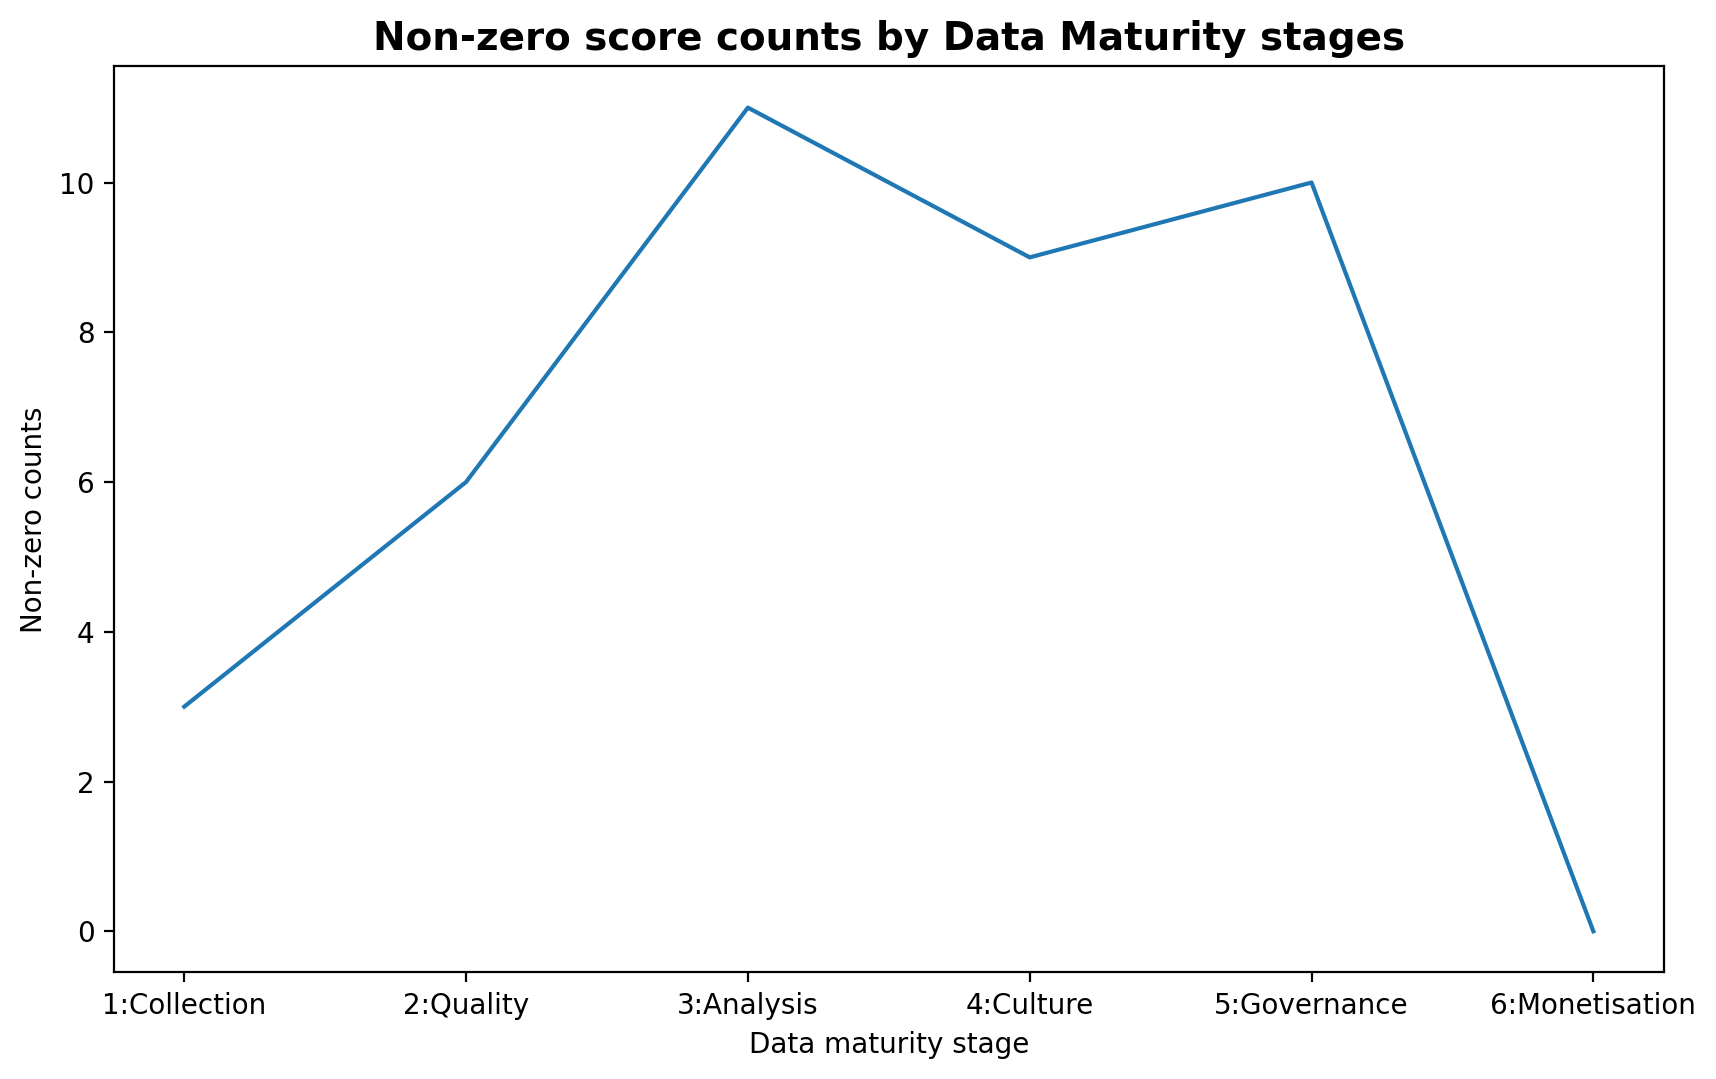

In [229]:
plt.figure(figsize=(10, 6), dpi=200)
x = ['1:Collection', '2:Quality', '3:Analysis', '4:Culture', '5:Governance', '6:Monetisation']
plt.plot(x, bins)
plt.xlabel('Data maturity stage')
plt.ylabel('Non-zero counts')
plt.title('Non-zero score counts by Data Maturity stages', size=14, weight='bold')
plt.show()

As opposed to a simple term search, a weighted TF-IDF does not return any score for the final data maturity stage. This shows that potential words that signify data monetisation found in the term search is not significant enough in the larger corpus of texts, and this is not surprising. To be able to score high in the TF-IDF, a term needs to be repeated enough to show up as significant for a single document, but not too much in the whole corpus in order to not be flagged as insignificant.

The score distribution above shows that the companies considered are mostly at stages 3 to 5 in the proposed data maturity model, meaning that they are fairly matured in the analysis and governance of data, and they also carry a good data culture. This does not imply a backward meaning that companies are poor at data collection and quality assurance; it only means that analysis, culture and governance are the more announced themes in these collections of texts.

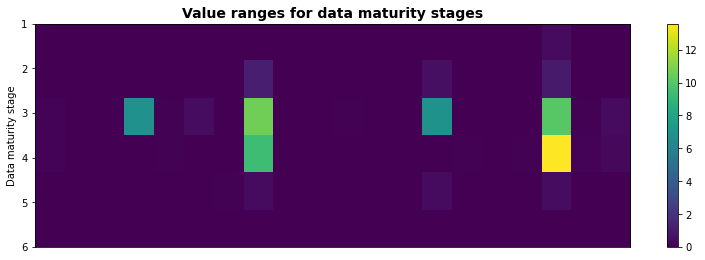

In [234]:
plt.matshow(
    summary_df_sorted.select_dtypes(exclude='object').transpose(),
    aspect='auto',
    extent=[1, 20, 6, 1]
    
)
plt.xticks([])
plt.ylabel('Data maturity stage')
plt.title('Value ranges for data maturity stages', size=14, weight='bold')
plt.colorbar()
plt.show()

The highest ranges of values are found for stage 3 (analysis) and 4 (culture) of the data maturity model, thus re-emphasising the fact that these stages are most announced in the collection of texts. The higher the TF-IDF score, the more meaningful mentions of data terms found for a company.

The below cells apply weightings to the current dataset, and we will visualise the weighted datasets to see the spread in the value range.

In [235]:
# Separate the numerical and categorical data to work separately with numerical columns
summary_df_sorted_num = summary_df_sorted.select_dtypes(exclude='object')
summary_df_sorted_cat = summary_df_sorted.select_dtypes(include='object')

In [170]:
# Add weights to individual stages, with higher stages enjoying higher weights

cols = summary_df_sorted_num.columns
summary_df_sorted_num_weighted = summary_df_sorted_num.copy()
for i in range(len(cols)):
    summary_df_sorted_num_weighted[cols[i]] *= (i+1)

In [172]:
# Concatenate the categorical columns with the reweighted numerical columns to display the 
# weighted dataset

weighted_summary_df = pd.concat(
    [
        summary_df_sorted_cat,
        summary_df_sorted_num_weighted
    ],
    axis=1
)

In [238]:
weighted_summary_df

,company,data_source,maturity_stage_1,maturity_stage_2,maturity_stage_3,maturity_stage_4,maturity_stage_5,maturity_stage_6
1,BHP,annual report,0.001354,0.000000,0.415941,0.443779,0.040349,0.0
1,BHP,company posts,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,BHP,privacy policy,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,BHP,job posts,0.000000,0.000000,20.583060,0.000000,0.000000,0.0
0,CBA,annual report,0.000000,0.000000,0.186737,0.370606,0.028971,0.0
0,CBA,company posts,0.000000,0.000000,1.338457,0.000000,0.000000,0.0
0,CBA,privacy policy,0.004791,0.024600,0.113364,0.209780,0.265998,0.0
0,CBA,job posts,0.000000,2.289900,31.850009,37.572294,1.985424,0.0
4,CSL,job posts,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,CSL,privacy policy,0.000000,0.000000,0.000000,0.000000,0.242044,0.0


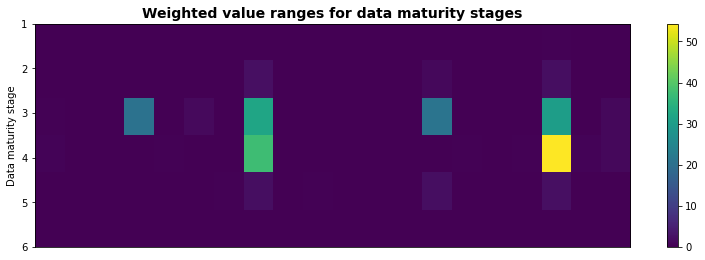

In [240]:
plt.matshow(
    weighted_summary_df.select_dtypes(exclude='object').transpose(),
    aspect='auto',
    extent=[1, 20, 6, 1]
    
)
plt.xticks([])
plt.ylabel('Data maturity stage')
plt.title('Weighted value ranges for data maturity stages', size=14, weight='bold')
plt.colorbar()
plt.show()

The main figure looks the same as the above, but the weights make those with higher TF-IDF scores for stages 3 and 4 even more announced, as seen in the wider spread in the value range.  

Next, we turn to the individual companies by calculating a weighted average of these scores, as mentioned above in the scoring system. The averaging makes the scores more interpretable and comparable.

## Interpretation across individual companies

In [173]:
scoring_vector = weighted_summary_df.groupby('company').sum().sum(axis=1)

In [236]:
wa_scoring_vector = scoring_vector / sum(DATA_DICTIONARY.keys())

In [237]:
wa_scoring_vector

company
BHP    1.023071
CBA    3.630520
CSL    0.021438
TLS    1.164261
WOW    4.408122
dtype: float64

From these scores, it's observed that WOW and CBA are noticeably more data mature than the rest, so they take the first rank. TLS and BHP are about the same in second ranking, while CSL is the least data mature in the cohort. This goes to show that from a purely textual analysis, the highest-ranked companies are consistently presenting meaningful texts about their data practices, and thus are more likely to be data-focused than lower-ranking companies.